# Himawari-8 data connector

This notebook provides a simple connector that allows to download, read and regrid the Himawari-8 data available in the 'noaa-himawari8' AWS S3 bucket. The connector used here could be improved and resigned in a way similar to the python interface to the 'noaa-goes16' and 'noaa-goes17' AWS S3 bucket provided by the goeasaws python package available under MIT license here: https://github.com/mnichol3/goesaws

The notebook relies on the boto3 libray to interect with Amazon S3 buckets (https://github.com/boto/boto3), SatPy and Pyresample to read, reproject and resample the satellite data (https://satpy.readthedocs.io/en/latest/index.html) and matplotlib to plot results.

First all required libraries are loaded

In [1]:
import boto3, os
from botocore.handlers import disable_signing
from satpy import Scene
from pyresample.utils import get_area_def
from matplotlib import pyplot as plt

Here is the code for the connector. This is a first version that was put quickly together. It is designed for Himawari-8 data but could easily be modified to interact with GOES data

In [2]:
class NOAA_AWS_Connector(object):
    
    def __init__(self, satellite):
        
        if not satellite in ['himawari8', 'goes16', 'goes17']:
            raise ValueError("satellite has to be 'himawari8' or 'goes16' or 'goes17'")
        self.satellite = satellite
        self.bucket_name = 'noaa-'+satellite
                             
        self.s3conn = boto3.resource('s3')
        self.s3conn.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
                             
        self.bucket = self.s3conn.Bucket(self.bucket_name)
        
        self.products = self._get_product_list()
        
    def _get_bucket_object_list(self, prefix_list):
        
        prefix = ''
        if prefix_list:
            prefix = "".join([p+"/" for p in prefix_list])
        
        return self.bucket.meta.client.list_objects_v2(Bucket=self.bucket_name,
                                                       Prefix=prefix,
                                                       Delimiter='/')
                             
    def _get_product_list(self):
                             
        info = self._get_bucket_object_list(prefix_list=None)
        
        return [prod['Prefix'].split("/")[0] for prod in info['CommonPrefixes']]
    
    def product_list(self):
        return self.products
    
    def get_product_years(self, product):
        
        if not product in self.products:
            raise ValueError("Invalid product name must be one of "+", ".join(self.products))
        
        info = self._get_bucket_object_list(prefix_list=[product])
        
        if not 'CommonPrefixes' in info:
            raise ValueError("No year available for that product")
        
        return [year_folder['Prefix'].split("/")[1] for year_folder in info['CommonPrefixes']]
    
    def get_product_months_for_year(self, product, year):
        
        info = self._get_bucket_object_list(prefix_list=[product, year])
        
        if not 'CommonPrefixes' in info:
            raise ValueError("No months available for that year")
        
        return [month_folder['Prefix'].split("/")[2] for month_folder in info['CommonPrefixes']]
    
    
    def get_product_days_for_month(self, product, year, month):
        
        info = self._get_bucket_object_list(prefix_list=[product, year, month])
        
        if not 'CommonPrefixes' in info:
            raise ValueError("No days available for that month")
        
        return [day_folder['Prefix'].split("/")[3] for day_folder in info['CommonPrefixes']]                 
    
    def get_product_times_for_day(self, product, year, month, day):
        
        info = self._get_bucket_object_list(prefix_list=[product, year, month, day])
        
        if not 'CommonPrefixes' in info:
            raise ValueError("No times available for that day")
        
        return [time_folder['Prefix'].split("/")[4] for time_folder in info['CommonPrefixes']]
    
    def get_product_files_for_time(self, product, year, month, day, time):
        
        info = self._get_bucket_object_list(prefix_list=[product, year, month, day, time])
        
        if not 'Contents' in info:
            print(info)
            raise ValueError("No files available for that time")
        
        return [file['Key'] for file in info['Contents']]
    
    def download_file(self, file_key, output_path):
        
        try:
            self.bucket.download_file(file_key, output_path)
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print("The file does not exist.")
            else:
                raise

Now let's instantiate a connector

In [3]:
h8_connector = NOAA_AWS_Connector(satellite='himawari8')

We list all the products available. All the L1 product are the RAW satellite images for the full disk (FLDK - this is a full picture of our side of the planete), Japan (Himawari-8 is owned by the Japanese Meteorological Agency and has a sensor dedicated to high resolution monitoring of the Japanse Islands) or the target area which generally to correspond to an area where extreme weather is happening and for which high resolution data are temprorarily recorded. The L2 product are derived product generated after processing of the satellite data.

In [33]:
h8_connector.product_list()

['AHI-L1b-FLDK',
 'AHI-L1b-Japan',
 'AHI-L1b-Target',
 'AHI-L2-FLDK-Clouds',
 'AHI-L2-FLDK-ISatSS',
 'AHI-L2-FLDK-RainfallRate',
 'AHI-L2-FLDK-SST',
 'AHI-L2-FLDK-Winds']

For now we choose the first product which is data and recusively query to select the year/month/day we want data for

In [5]:
years = h8_connector.get_product_years(product=h8_connector.products[0])
years

['2019', '2020']

In [7]:
months = h8_connector.get_product_months_for_year(product=h8_connector.products[0],
                                                   year='2020')
months

['01', '02', '03', '04', '05', '06']

In [9]:
days = h8_connector.get_product_days_for_month(product=h8_connector.products[0],
                                                year='2020',
                                                month='04')
days

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30']

In [10]:
times = h8_connector.get_product_times_for_day(product=h8_connector.products[0],
                                                year='2020',
                                                month='04',
                                                day='30')
times

['0000',
 '0010',
 '0020',
 '0030',
 '0040',
 '0050',
 '0100',
 '0110',
 '0120',
 '0130',
 '0140',
 '0150',
 '0200',
 '0210',
 '0220',
 '0230',
 '0250',
 '0300',
 '0310',
 '0320',
 '0330',
 '0340',
 '0350',
 '0400',
 '0410',
 '0420',
 '0430',
 '0440',
 '0450',
 '0500',
 '0510',
 '0520',
 '0530',
 '0540',
 '0550',
 '0600',
 '0610',
 '0620',
 '0630',
 '0640',
 '0650',
 '0700',
 '0710',
 '0720',
 '0730',
 '0740',
 '0750',
 '0800',
 '0810',
 '0820',
 '0830',
 '0840',
 '0850',
 '0900',
 '0910',
 '0920',
 '0930',
 '0940',
 '0950',
 '1000',
 '1010',
 '1020',
 '1030',
 '1040',
 '1050',
 '1100',
 '1110',
 '1120',
 '1130',
 '1140',
 '1150',
 '1200',
 '1210',
 '1220',
 '1230',
 '1240',
 '1250',
 '1300',
 '1310',
 '1320',
 '1330',
 '1340',
 '1350',
 '1400',
 '1410',
 '1420',
 '1430',
 '1450',
 '1500',
 '1510',
 '1520',
 '1530',
 '1540',
 '1550',
 '1600',
 '1610',
 '1620',
 '1630',
 '1640',
 '1650',
 '1700',
 '1710',
 '1720',
 '1730',
 '1740',
 '1750',
 '1800',
 '1810',
 '1820',
 '1830',
 '1840',
 

Now we are at the bottom of the folder tree and retrieve the name of the files available. Himawari-8 is a multispectral imager and records its data for 16 different spectral bands (imager specification can be found here https://www.data.jma.go.jp/mscweb/en/himawari89/space_segment/spsg_ahi.html). The data for each band is split into 10 segments illustrated here (https://www.data.jma.go.jp/mscweb/en/himawari89/cloud_service/cloud_service.html) which is identified by the Sxxxx part of the file name. S0810 means segment 8 out of 10. All files are stored in Himawari Standard Format and zipped.

In [13]:
files = h8_connector.get_product_files_for_time(product=h8_connector.products[0],
                                                year='2020',
                                                month='06',
                                                day='05',
                                                time='0000')
files

['AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0110.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0210.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0310.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0410.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0510.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0610.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0710.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0810.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S0910.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B01_FLDK_R10_S1010.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B02_FLDK_R10_S0110.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/0000/HS_H08_20200605_0000_B02_FLDK_R10_S0210.DAT.bz2',
 'AHI-L1b-FLDK/2020/06/05/00

We select the file that correspond to band 3 (the highest resolution visible band) and only the segment that includes New Zealand

In [14]:
file_to_download = [f for f in files if '_B03_' in f and 'S0910' in f][0]
print(file_to_download.split("/")[-1])

HS_H08_20200605_0000_B03_FLDK_R05_S0910.DAT.bz2


In [15]:
h8_connector.download_file(file_to_download, '/tmp/'+file_to_download.split("/")[-1])

Once the file is downloaded it can be loaded as a satpy scene

In [16]:
scn = Scene(sensor='ahi', filenames=['/tmp/'+file_to_download.split("/")[-1]], reader='ahi_hsd')

In [17]:
scn.load(['B03'])

/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local

Now lets reproject the data over an area that includes the whole of New Zealand.
Because we want to look at physical objects in the data we choose a distance-preserving coordinate system (Al). This is a local coordinate system that we roughtly center on Wellington.
First we define the domain we want the data over

In [18]:
# Name of the area
area_id = 'new-zealand'

# Projection
proj_id = 'laeqd_-174.0_-41.0' # Arbitrary name
projection = '+proj=aeqd +lat_0=-41.0 +lon_0=174 +ellps=WGS84' # Proj4 projection definition

# We define the area of the output in the output corrdinate system
area_extent = (-601000.0, -801000.0, 601000.0, 801000.0)
# We define the number of point in each direction
x_size = 1201
y_size = 1601

# WE put together all those information in an area definition
description = "New Zealand"
areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

/home/sebastien/.local/lib/python3.6/site-packages/pyresample/utils/__init__.py:34: UserWarning: 'get_area_def' has moved, import it with 'from pyresample import get_area_def'
  warnings.warn("'get_area_def' has moved, import it with 'from pyresample import get_area_def'")


Now we can run the resampling routine

In [19]:
local_scene = scn.resample(areadef)

/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


For convenience we retrieve the data in the shape of a xarray dataset which can then easily be displayed using matplotlib

In [21]:
dset = local_scene.to_xarray_dataset()

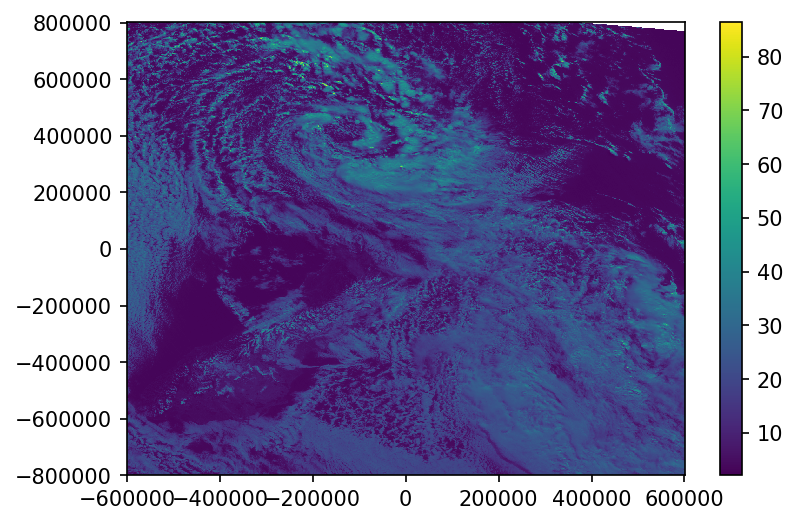

In [22]:
%matplotlib inline
plt.figure(dpi=150)
plt.pcolor(dset.x, dset.y, dset.B03)
plt.colorbar()

The previous plot shows the whole of New Zealand at a resolution of about 2km which is about the resolution of Himawari-8 for most of its channels. However, channel 3 is the channel that has the highest (about 500m) so we repeat the previous operation to produce a high resolution zoomed-in plot of the top of the north island.

In [23]:
# Name of the area
area_id = 'new-zealand-zoomed'

# Projection
proj_id = 'laeqd_-174.0_-41.0' # Arbitrary name
projection = '+proj=aeqd +lat_0=-41.0 +lon_0=174 +ellps=WGS84' # Proj4 projection definition

# We define the area of the output in the output corrdinate system
area_extent = (-200250.0, 200250.0, 200250.0, 600250.0)
# We define the number of point in each direction
x_size = 801 #501
y_size = 801 #701

# WE put together all those information in an area definition
description = "New Zealand Zoomed"
zoomed_areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

/home/sebastien/.local/lib/python3.6/site-packages/pyresample/utils/__init__.py:34: UserWarning: 'get_area_def' has moved, import it with 'from pyresample import get_area_def'
  warnings.warn("'get_area_def' has moved, import it with 'from pyresample import get_area_def'")


In [24]:
zoomed_scene = scn.resample(zoomed_areadef)

/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/sebastien/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [25]:
zoomed_dset = zoomed_scene.to_xarray_dataset()

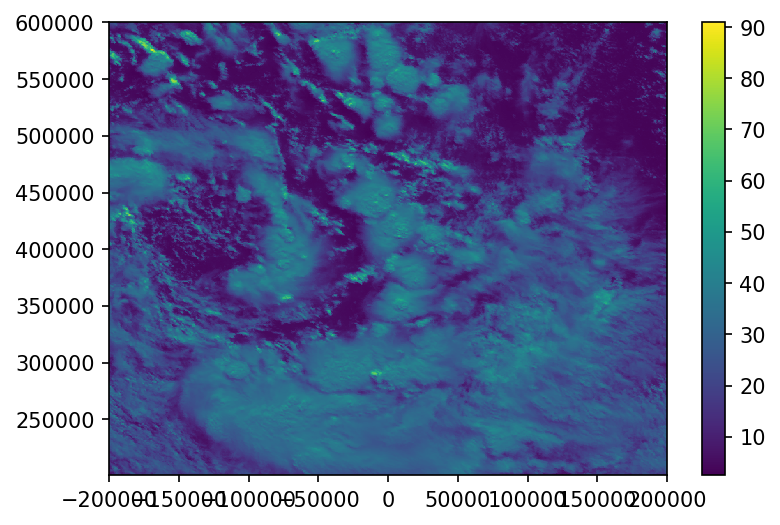

In [26]:
%matplotlib inline
plt.figure(dpi=150)
plt.pcolor(zoomed_dset.x, zoomed_dset.y, zoomed_dset.B03)
plt.colorbar()

Here we show quickly how to navigate the goes16 folder tree to find available data

In [27]:
h8_connector = NOAA_AWS_Connector(satellite='goes16')

In [29]:
products = h8_connector.product_list()
products
years = h8_connector.get_product_years(products[0])
years

['2000', '2017', '2018', '2019', '2020']

In [75]:
years = h8_connector.get_product_years(products[0])
years

['2000', '2017', '2018', '2019', '2020']

Goes does not have folders for months but instead numbers days for the whole year.

In [30]:
days = h8_connector.get_product_months_for_year(products[0], '2020')
days

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


In [31]:
files = [f['Key'] for f in h8_connector._get_bucket_object_list(prefix_list=[products[0], '2020', '156', '23'])['Contents']]
files

['ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562301139_e20201562303512_c20201562303558.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562306139_e20201562308512_c20201562308556.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562311139_e20201562313512_c20201562313566.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562316139_e20201562318512_c20201562318564.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562321139_e20201562323512_c20201562323565.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562326139_e20201562328512_c20201562328563.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562331139_e20201562333512_c20201562333557.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562336139_e20201562338512_c20201562338564.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C01_G16_s20201562341139_e20201562343512_c20201562343557.nc',
 'ABI-L1b-RadC/2020/156/23/OR_ABI-L1b-RadC-M6C

All those files are netcdf and can be loaded using xarray directly